Lokalno ucitavanje UrbanSound8k dataset-a:

In [1]:
!wget https://zenodo.org/record/1203745/files/UrbanSound8K.tar.gz -O urban8k.tgz
!tar -xzf urban8k.tgz
!rm urban8k.tgz

--2023-06-03 15:32:58--  https://zenodo.org/record/1203745/files/UrbanSound8K.tar.gz
Resolving zenodo.org (zenodo.org)... 188.185.124.72
Connecting to zenodo.org (zenodo.org)|188.185.124.72|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6023741708 (5.6G) [application/octet-stream]
Saving to: ‘urban8k.tgz’

urban8k.tgz         100%[===================>]   5.61G  26.7MB/s    in 3m 39s  

2023-06-03 15:36:39 (26.2 MB/s) - ‘urban8k.tgz’ saved [6023741708/6023741708]



In [19]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [20]:
directory_path = '/content/drive/MyDrive/UrbanSound Classification - Domaci/'

Podesavanja:

In [22]:
import os

root_folder=directory_path

MFCC_folder=os.path.join(root_folder,'MFCC')
if not os.path.exists(MFCC_folder):
    os.mkdir(MFCC_folder)

MFCC_vec_folder=os.path.join(root_folder,'MFCC_vec')
if not os.path.exists(MFCC_vec_folder):
    os.mkdir(MFCC_vec_folder)

Mel_folder=os.path.join(root_folder,'Mel')
if not os.path.exists(Mel_folder):
    os.mkdir(Mel_folder)

Mel_vec_folder=os.path.join(root_folder,'Mel_vec')
if not os.path.exists(Mel_vec_folder):
    os.mkdir(Mel_vec_folder)

for i in range(1,11):
    fold_folder_MFCC=os.path.join(MFCC_folder,'fold_'+str(i))
    if not os.path.exists(fold_folder_MFCC):
        os.mkdir(fold_folder_MFCC)
    fold_folder_Mel = os.path.join(Mel_folder, 'fold_' + str(i))
    if not os.path.exists(fold_folder_Mel):
        os.mkdir(fold_folder_Mel)
    fold_folder_MFCC_vec = os.path.join(MFCC_vec_folder, 'fold_' + str(i))
    if not os.path.exists(fold_folder_MFCC_vec):
        os.mkdir(fold_folder_MFCC_vec)
    fold_folder_Mel_vec = os.path.join(Mel_vec_folder, 'fold_' + str(i))
    if not os.path.exists(fold_folder_Mel_vec):
        os.mkdir(fold_folder_Mel_vec)


batch_size=32
init_lr = 1e-3
early_stopping_patience = 15
reduce_lr_patience = 8

input_size=(1,13,344,1) # MFCC
#input_size=(1,64,344,1) # Mel  
#input_size=(1,5,4,1) # MFCC - vec
#input_size=(1,8,8,1) # MFCC - vec


In [23]:
import pandas as pd
import numpy as np
pd.plotting.register_matplotlib_converters()
import random
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime

In [24]:
# Libraries for Classification and building Models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPool2D, Dropout
from tensorflow.keras.utils import to_categorical 
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import tensorflow as tf

In [25]:
# Project Specific Libraries
import librosa
import librosa.display
import glob 
#import skimage

In [26]:
audio_path="UrbanSound8K/audio/"
metadata_path="UrbanSound8K/metadata/UrbanSound8K.csv"
df = pd.read_csv(metadata_path)

'''We will extract classes from this metadata.'''

df.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


In [29]:
dat1, sampling_rate1 = librosa.load(audio_path+"fold5/100032-3-0-0.wav")
dat2, sampling_rate2 = librosa.load(audio_path+"fold5/100263-2-0-117.wav")

Pomocna klasa za preprocesiranje audio fajlova:

In [42]:
class AudioPrep:
    @staticmethod
    def open_audio_file(audio_file):
        sig, sr=librosa.load(audio_file, mono=False)
        return (sig, sr)
    @staticmethod
    def rechannel(aud, new_channel):
        sig, sr = aud
        if (sig.shape[0] == new_channel):
            # Nothing to do
            return aud
        if (new_channel == 1):
            # Convert from stereo to mono by selecting only the first channel
            resig=librosa.to_mono(sig)
        else:
            # Convert from mono to stereo by duplicating the first channel
            resig = librosa.util.stack([sig, sig])
        return ((resig, sr))
    @staticmethod
    def resample(aud, newsr):
        sig, sr = aud
        if (sr == newsr):
            # Nothing to do
            return aud
        num_channels = sig.shape[0]
        # Resample first channel
        if (num_channels > 1 and len(sig.shape)>1):
            # Resample the second channel and merge both channels
            reone = librosa.resample(y=sig[0,:],orig_sr= sr,target_sr= newsr)
            retwo = librosa.resample(y=sig[1,:],orig_sr= sr,target_sr= newsr,)
            resig = librosa.util.stack([reone, retwo])
        else:
            resig=librosa.resample(sig, orig_sr=sr, target_sr=newsr)
        return ((resig, newsr))
    @staticmethod
    def pad_trunc(aud, max_ms):
        sig, sr = aud
        sig_len=0
        if (len(sig.shape)>1):
            sig_len = sig.shape[1]
        else:
            sig_len=len(sig)
        max_len = sr//1000 * max_ms
        if (sig_len > max_len or sig_len < max_len):
            # Truncate the signal to the given length
            sig=librosa.util.fix_length(sig, size=max_len)
        return (sig, sr)
    @staticmethod
    def time_shift(aud, shift_limit):
        sig,sr = aud
        _, sig_len = sig.shape
        shift_amt = int(random.random() * shift_limit * sig_len)
        return (sig.roll(shift_amt), sr)
    @staticmethod
    def mel_spectrogram(aud, n_mels=64, n_fft=1024):
        sig,sr = aud
        top_db = 80
        spec=librosa.feature.melspectrogram(y=sig, sr=sr,n_mels=n_mels, n_fft=n_fft)
        spec=librosa.power_to_db(spec, ref=np.max)
        return spec
    @staticmethod
    def mel_spectrogram_vec(aud, n_mels=64, n_fft=1024):
        sig,sr = aud
        top_db = 80
        spec=np.mean(librosa.feature.melspectrogram(y=sig, sr=sr,n_mels=n_mels, n_fft=n_fft).T,axis=0)
        spec=librosa.power_to_db(spec, ref=np.max)
        return spec
    @staticmethod
    def mfccs(aud, n_mfcc=13):
        sig,sr = aud
        spec = librosa.feature.mfcc(y=sig, sr=sr, n_mfcc=n_mfcc)
        return spec
    @staticmethod
    def mfccs_vec(aud, n_mfcc=20):
        sig,sr = aud
        spec = np.mean(librosa.feature.mfcc(y=sig, sr=sr, n_mfcc=n_mfcc).T,axis=0)
        return spec

Pomocna klasa za ucitavanje feature-a audio fajlova:

In [47]:
class SoundDS:
    def __init__(self, df, data_path):
        self.df=df
        self.data_path=str(data_path)
        self.duration=4000
        self.sr=44100
        self.channel=1
        self.shift_pct=0.4
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        audio_file=self.data_path+ str(self.df["fold"][idx]) + '/' + self.df["slice_file_name"][idx]
        class_id=self.df["classID"][idx]
        aud=AudioPrep.open_audio_file(audio_file)
        rechan=AudioPrep.rechannel(aud,self.channel)
        reaud=AudioPrep.resample(rechan, self.sr)
        dur_aud=AudioPrep.pad_trunc(reaud, self.duration)
        #feature = AudioPrep.mel_spectrogram(dur_aud,n_fft=1024)
        feature=AudioPrep.mfccs(dur_aud)
        fold=self.df['fold'][idx]
        return feature, class_id, fold
        

Model:

In [49]:
from keras.callbacks import EarlyStopping
from keras.layers import Dense, Conv2D,  MaxPool2D, Flatten, GlobalAveragePooling2D,  BatchNormalization, Layer, Add
from keras.models import Sequential
from keras.models import Model
import tensorflow as tf

class ResnetBlock(Layer):
    """
    A standard resnet block.
    """

    def __init__(self, channels: int, down_sample=False):
        """
        channels: same as number of convolution kernels
        """
        super().__init__()

        self.__channels = channels
        self.__down_sample = down_sample
        self.__strides = [2, 1] if down_sample else [1, 1]

        KERNEL_SIZE = (3, 3)
        INIT_SCHEME = "he_normal"

        self.conv_1 = Conv2D(self.__channels, strides=self.__strides[0],
                             kernel_size=KERNEL_SIZE, padding="same", kernel_initializer=INIT_SCHEME)
        self.bn_1 = BatchNormalization()
        self.conv_2 = Conv2D(self.__channels, strides=self.__strides[1],
                             kernel_size=KERNEL_SIZE, padding="same", kernel_initializer=INIT_SCHEME)
        self.bn_2 = BatchNormalization()
        self.merge = Add()

        if self.__down_sample:
            # perform down sampling using stride of 2
            self.res_conv = Conv2D(
                self.__channels, strides=2, kernel_size=(1, 1), kernel_initializer=INIT_SCHEME, padding="same")
            self.res_bn = BatchNormalization()

    def call(self, inputs):
        res = inputs

        x = self.conv_1(inputs)
        x = self.bn_1(x)
        x = tf.nn.relu(x)
        x = self.conv_2(x)
        x = self.bn_2(x)

        if self.__down_sample:
            res = self.res_conv(res)
            res = self.res_bn(res)

        # if not perform down sample, then add a shortcut directly
        x = self.merge([x, res])
        out = tf.nn.relu(x)
        return out

class ResNet18(Model):

    def __init__(self, num_classes, **kwargs):
        """
            num_classes: number of classes in specific classification task.
        """
        super().__init__(**kwargs)
        self.conv_1 = Conv2D(64, (7, 7), strides=2,
                             padding="same", kernel_initializer="he_normal")
        self.init_bn = BatchNormalization()
        self.pool_2 = MaxPool2D(pool_size=(2, 2), strides=2, padding="same")
        self.res_1_1 = ResnetBlock(64)
        self.res_1_2 = ResnetBlock(64)
        self.res_2_1 = ResnetBlock(128, down_sample=True)
        self.res_2_2 = ResnetBlock(128)
        self.res_3_1 = ResnetBlock(256, down_sample=True)
        self.res_3_2 = ResnetBlock(256)
        self.res_4_1 = ResnetBlock(512, down_sample=True)
        self.res_4_2 = ResnetBlock(512)
        self.avg_pool = GlobalAveragePooling2D()
        self.flat = Flatten()
        self.fc = Dense(num_classes, activation="softmax")

    def call(self, inputs):
        out = self.conv_1(inputs)
        out = self.init_bn(out)
        out = tf.nn.relu(out)
        out = self.pool_2(out)
        for res_block in [self.res_1_1, self.res_1_2, self.res_2_1, self.res_2_2, self.res_3_1, self.res_3_2, self.res_4_1, self.res_4_2]:
            out = res_block(out)
        out = self.avg_pool(out)
        out = self.flat(out)
        out = self.fc(out)
        return out

def create_model():
    model = ResNet18(10)
    model.build(input_shape=input_size)
    return model

Ucitavanje podataka:

In [52]:
def load_data():
    metadata=pd.read_csv(metadata_path)
    audioDS=SoundDS(metadata, audio_path+"/fold")

    features=[]
    folds=[]
    labels=[]
    loaded_item_num=0
    for i in range(len(metadata)):
        feature, label, fold=audioDS.__getitem__(i)
        features.append(feature)
        labels.append(label)
        folds.append(fold)
        print("\r", loaded_item_num +i+1, "/8732", end="")
    print("\r\n")
    folds_np = np.array(folds)
    features_np = np.array(features)
    labels_np = np.array(labels)
    return features_np, labels_np, folds_np

print("\n-----Data preparation-----\n")
start = datetime.now()
features, labels, folds=load_data()
labels=to_categorical(labels)
duration = datetime.now() - start
print("\n-----Data ready for training (preparation time ", duration, ")-----\n")


-----Data preparation-----

 8732 /8732


-----Data ready for training (preparation time  0:05:50.603628 )-----



In [53]:
features.shape

(8732, 13, 344)

Treniranje:

(8732, 13, 344)


Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/50
246/246 [==============================] - ETA: 0s - loss: 1.4732 - categorical_accuracy: 0.4942
Epoch 1: val_categorical_accuracy improved from -inf to 0.42955, saving model to /content/drive/MyDrive/UrbanSound Classification - Domaci/MFCC/fold_1/training_weights.h5
246/246 [==============================] - 36s 39ms/step - loss: 1.4732 - categorical_accuracy: 0.4942 - val_loss: 2.3491 - val_categorical_accuracy: 0.4296 - lr: 0.0010
Epoch 2/50
245/246 [============================>.] - ETA: 0s - loss: 1.0854 - categorical_accuracy: 0.6230
Epoch 2: val_categorical_accuracy did not improve from 0.42955
246/246 [==============================] - 8s 32ms/step - loss: 1.0844 - categorical_accuracy: 0.6234 - val_loss: 2.5820 - val_categorical_accurac

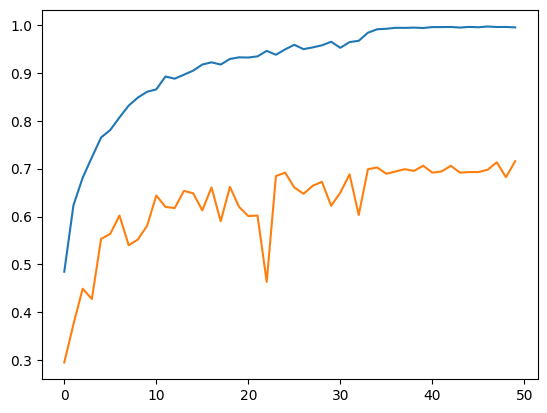

In [54]:
########################################################################################################################
# START OF K-FOLD CROSS VALIDATION
########################################################################################################################

print(features.shape)
acc_per_fold=[]
loss_per_fold=[]
histories=[]
fold_idx=np.arange(1, 11)
for fold in fold_idx:
    test_X=features[np.where(folds==fold)]
    test_Y=labels[np.where(folds==fold)]
    train_X=features[np.where(folds!=fold)]
    train_Y=labels[np.where(folds!=fold)]

    if(len(train_X.shape)==3): # if audio files are mono
        test_X=tf.reshape(test_X, [test_X.shape[0], test_X.shape[1], test_X.shape[2],1])
        train_X=tf.reshape(train_X, [train_X.shape[0], train_X.shape[1], train_X.shape[2],1])

    model = create_model()
    model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss=tf.keras.losses.categorical_crossentropy,
                  metrics=[tf.keras.metrics.categorical_accuracy])
    path=MFCC_folder+"/fold_"+str(fold)+"/"
    save_model = tf.keras.callbacks.ModelCheckpoint(path + "training_weights.h5",
                                                    monitor='val_categorical_accuracy', mode='max',
                                                    verbose=1, save_best_only=True,save_weights_only=True)

    csv_logger = tf.keras.callbacks.CSVLogger(path + 'training.csv')

    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_categorical_accuracy', mode='max', verbose=1,
                                                      patience=early_stopping_patience, restore_best_weights=True)

    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_categorical_accuracy', mode='max', verbose=1,
                                                     factor=0.1, patience=reduce_lr_patience)

    # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold} ...')

    start = datetime.now()

    history = model.fit(train_X,train_Y,
                        batch_size = batch_size,
                        validation_data=(test_X, test_Y),
                        epochs=50,
                        callbacks=[save_model, csv_logger, early_stopping, reduce_lr])

    duration = datetime.now() - start

    histories.append(history)

    plt.clf()
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.savefig(path + "training_loss_plot"+str(fold)+".png")

    plt.clf()
    plt.plot(history.history['categorical_accuracy'])
    plt.plot(history.history['val_categorical_accuracy'])
    plt.savefig(path + "training_accuracy_plot"+str(fold)+".png")

    ########################################################################################################################
    # EVALUATE MODEL
    ########################################################################################################################

    scores = model.evaluate(test_X, test_Y, verbose=0)
    print(f'Score for fold {fold}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1] * 100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])


Grafici:

In [ ]:
for i in range(0,10):
    _ = plt.figure(figsize=(6,4))
    _ = plt.title('Accuracy for Fold '+str(i+1))
    _ = plt.plot(histories[i].history['accuracy'], label='train')
    _ = plt.plot(histories[i].history['val_accuracy'], label='test')
    _ = plt.legend()
    plt.show()

for i in range(0,10):
    _ = plt.figure(figsize=(6,4))
    _ = plt.title('Loss for Fold '+str(i+1))
    _ = plt.plot(histories[i].history['loss'], label='train')
    _ = plt.plot(histories[i].history['val_loss'], label='test')
    _ = plt.legend()
    plt.show()

Evaluacija:

In [55]:
final_score=np.mean(acc_per_fold)
np.mean(acc_per_fold)

65.8833658695221